In [1]:
class Point:
    def __init__(self, x=None, y=None):        
        self.coord = None
        if (x is not None) and (y is not None):
            self.coord = (x,y)
        else:
            self.coord = (10,10) #int(random.random() * 200)



In [2]:
import numpy as np

class Individ:
    def __init__(self, step, size): 
        self.route = np.random.randint(-1,2, size=(2,size))*step  #   step*(-1) / step*1 / step*0
        self.individ_size = size
        self.fitness = 0
        self.setfitness()
        
    def setfitness(self):    #start_point = (x,y)
        global start_point
        global end_point
        global gameField
        cumsum = np.cumsum(self.route, axis=1) + np.array(start_point).reshape((2,1))
        index = self.checkblocks(cumsum, gameField)
        #print ('cumsum ', cumsum[:, index])
        distance = np.linalg.norm(cumsum[:, index] - np.array(end_point))      
        self.fitness = distance    # check normalization   
        
    def getfitness(self):
        return self.fitness
    
    def checkblocks(self, cumsum, our_field):
        global gameField
        for i in range(1, self.individ_size):
            if (any(cumsum[:, i] < 0) or (cumsum[0, i] >= gameField.field_size[0]) or (cumsum[1, i] >= gameField.field_size[1])):
                return i-1 
            elif gameField.getvalue(cumsum[0, i], cumsum[1, i]):
                return i-1
        return self.individ_size-1
    
    def getFinalRoute(self):
        global start_point
        global end_point
        global gameField
        cumsum = np.cumsum(self.route, axis=1) + np.array(start_point).reshape((2,1))
        index = self.checkblocks(cumsum, gameField)
        return cumsum[:, :index+1]
    
        

In [61]:
class Field:
    def __init__(self, size):
        self.matrix = np.zeros(size)
        self.matrix[0, :] = 1
        self.matrix[:, 0] = 1
        self.matrix[:, size[1]-1] = 1
        self.matrix[size[0]-1, :] = 1
        self.field_size = size
    
    def addSquareBlock(self, left_top, right_bottom):  #point = (x,y)
        for i in range(left_top[0], right_bottom[0]):
            for j in range(left_top[1],right_bottom[1]):
                self.matrix[i, j] = 1
                
    def addCircle(self, center, radius): # center = (x,y)
        for i in range(min(0,center[0]-radius), max(self.field_size[0],center[0]+radius)):
            for j in range(min(0,center[1]-radius), max(self.field_size[1],center[1]+radius)):
                if (center[0]-i)**2+(center[1]-j)**2 <= radius**2:
                    self.matrix[i, j] = 1
    
    # add diff shapes of blocks
        
    def getmatrix(self):
        return self.matrix
    
    def getvalue(self,x,y):
        return self.matrix[x,y]
    
        
        

In [4]:
import operator

class Population:
    def __init__(self, step, individSize, populationSize): #, start_point, end_point, our_field):
        self.population = []
        #self.fitness = []
        for i in range(0, populationSize):
            newInd = Individ(step, individSize) #, start_point, end_point, our_field)
            self.population.append(newInd)            
            #self.fitness.append(newInd.fitness)
                
    def getFitness(self):
        fitness = [x.fitness for x in self.population]
        return fitness
        #return self.fitness
    
    def getBest(self,n):        
        #sortedPopulation = [pop for _,pop in sorted(zip(self.fitness, self.population), key = lambda x: x[0])]    
        sortedPopulation = sorted(self.population,key=operator.attrgetter("fitness"))
        if n==1:
            return sortedPopulation[0]
        else:
            return sortedPopulation[:n]
    
    def add_individ(self, newIndivid):
        self.population.append(newIndivid)
        #self.fitness.append(newIndivid.fitness)
    
        
    
    

In [6]:
import random
import copy

class GA:
    def __init__(self, user_mutationRate, user_crossoverProbability, user_elitism, 
                 user_crossoverFunction, user_parentSelection):
        
        self.mutationRate = user_mutationRate
        #self.tournamentSize = 10
        self.crossoverProbability = user_crossoverProbability
        self.elitism = user_elitism
        
        if user_crossoverFunction == 1:
            self.crossover = self.crossover_1point
        elif user_crossoverFunction == 2:
            self.crossover = self.crossover_2point
            
        if user_parentSelection == 'wheel':
            self.chooseParents = self.chooseParents_wheel
        elif user_parentSelection == 'tournament':
            self.chooseParents = self.chooseParents_tournament
        
    def CreateFirstPopulation(self, user_step, user_individSize, user_populationSize):
        initialPop = Population(step=user_step, individSize=user_individSize, populationSize=user_populationSize)                                 
        return initialPop
        
    def chooseParents_wheel(self, generation):
        reversed_fitness = 1.0/np.array(generation.getFitness())
        select_prob = reversed_fitness/sum(reversed_fitness)
        selected = np.random.choice(generation.population, 2, replace=False)#p=select_prob, replace=False)
        return list(selected)
    
    def chooseParents_tournament(self, generation):
        
        #   ADD FUNCTION HERE !!!!
        
        return list(parents)
    
    def get_breakes(self,n):
        break1,break2 = random.sample(range(0, n), 2)
        if break1<break2: 
            return(break1,break2)
        else:
            return(break2,break1)
    
    def crossover_2point(self, parents):        
        children = copy.deepcopy(parents)
        pp = random.random()
        if pp <= self.crossoverProbability:  
            startPos,endPos = self.get_breakes(parents[0].individ_size) 
            children[0].route[:, startPos:endPos], children[1].route[:, startPos:endPos] = \
                copy.deepcopy(children[1].route[:, startPos:endPos]), copy.deepcopy(children[0].route[:, startPos:endPos])                  
        return children
    
    def crossover_1point(self, parents):        
        children = copy.deepcopy(parents)
        pp = random.random()
        if pp <= self.crossoverProbability:  
            startPos = random.randint(0,parents[0].individ_size)
            children[0].route[:, startPos:], children[1].route[:, startPos:] = \
                copy.deepcopy(children[1].route[:, startPos:]), copy.deepcopy(children[0].route[:, startPos:])                
        return children
    
    def mutate(self, children):
        if random.random() < self.mutationRate:
            indx = random.randint(0, children[0].individ_size-1)
            children[0].route[0, indx], children[0].route[1, indx] = children[0].route[1, indx].copy(), children[0].route[0, indx].copy()
            
        if random.random() < self.mutationRate:
            indx = random.randint(0, children[1].individ_size-1)
            children[1].route[0, indx], children[1].route[1, indx] = children[1].route[1, indx].copy(), children[1].route[0, indx].copy()
            
        return children
    
    def fittest(self, child_list, n): # n - how much return
        child_list.sort(key = lambda x: x.fitness)
        return child_list[:n]
              
        
    def evolve(self, step, individSize, populationSize, generation, user_chooseFromAll):  #generation - previous population

        children_list = []
        for i in range(populationSize):
            #choose parents
            parents = self.chooseParents(generation)

            #make 2 children
            children = self.crossover(parents)

            #mutate
            children = self.mutate(children)

            children[0].setfitness()
            children[1].setfitness() 
            
            children_list = children_list + children
        
    
        #Create new generation with elitism?
        if user_chooseFromAll:
            newPopulation = Population(step = step, individSize = individSize, populationSize = 0)                                        
            for child in children_list:
                generation.add_individ(child)
            best_individs = generation.getBest(populationSize)
            for individ in best_individs:
                newPopulation.add_individ(individ)
        else:
            newPopulation = Population(step = step, individSize = individSize, populationSize = 0)                                        
            if self.elitism:
                newPopulation.add_individ(generation.getBest(1))                
                best_children = self.fittest(children_list, populationSize-1)
            else:
                best_children = self.fittest(children_list, populationSize)
            for child in best_children:
                newPopulation.add_individ(child)       
                                 
        return newPopulation
        

In [87]:
# common parameters for all users
gameField = Field(size = (100, 100))
gameField.addSquareBlock((41,20),(100,40))
gameField.addSquareBlock((0,60),(59,80))
#gameField.addSquareBlock((40,60),(60,70))
#gameField.addCircle((70,70),10)

start_point = (50, 10)
end_point = (50, 90)

# parameters of one user
mutationRate=0.1
crossoverProbability=0.7
elitism=True
step=2
individSize=150
populationSize=100
chooseFromAll = False
crossoverFunc = 2
parentFunc = 'wheel'


ga = GA(user_mutationRate=mutationRate, user_crossoverProbability=crossoverProbability, user_elitism=elitism,
       user_crossoverFunction = crossoverFunc, user_parentSelection = parentFunc) 
initialPop = ga.CreateFirstPopulation(user_step=step, user_individSize=individSize, user_populationSize=populationSize)
print('min fitness ', min(initialPop.getFitness()))
print('evolve function: ')
while not any(np.array(initialPop.getFitness()) ==0):
    initialPop = ga.evolve(step = step, individSize = individSize, populationSize = populationSize, generation = initialPop, 
                          user_chooseFromAll = chooseFromAll)    
    #print('all fitness ', initialPop.getFitness())
    print('min fitness ', min(initialPop.getFitness()))

best_individ = initialPop.getBest(1)

min fitness  64.7765389628
evolve function: 
min fitness  60.827625303
min fitness  58.2408791142
min fitness  52.9528091795
min fitness  32.0624390838
min fitness  32.0624390838
min fitness  32.0624390838
min fitness  32.0624390838
min fitness  32.0624390838
min fitness  32.0624390838
min fitness  32.0624390838
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  32.0
min fitness  30.5286750449
min fitness  30.5286750449
min fitness  27.2029410175
min fitness  27.2029410175
min fitness  27.2029410175
min fitness  27.2029410175
min fitness  27.2029410175
min fitness  26.0
min fitness  26.0
min fitness  25.6124969497
min fitness  24.1660919472
min fitness  22.803508502
min fitness  22.803508502
min fitness  17.2046505341
min fitness  17.2046505341
min fitness  17.2046505341
min fitness  17.2046505341
min fitness  12.8062484749
min fitness  10.770329

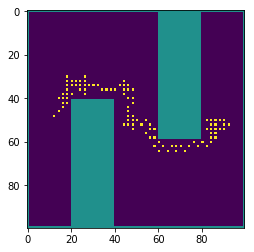

In [88]:
import matplotlib.pyplot as plt
route = best_individ.getFinalRoute()
matr = gameField.matrix
for i in range(len(route[0])):
    matr[route[0][i], route[1][i]] = 2
im = plt.imshow(matr)
im.figure

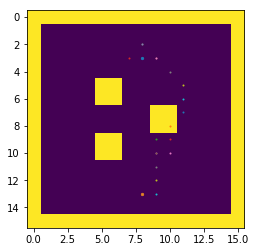

In [47]:
import matplotlib.pyplot as plt
route = best_individ.getFinalRoute()
matr = gameField.matrix
for i in range(len(route[0])):
    matr[route[0][i], route[1][i]] = 2
fig, ax = plt.subplots()
ax.imshow(gameField.matrix)
#ax.scatter(start_point[0], start_point[1],s=5)
#ax.scatter(end_point[0], end_point[1],s=5)
for i in range(len(route[0])):
    ax.scatter(route[0][i], route[1][i],s=1)
plt.show()
#fig.savefig('test.png',dpi=500)